In [1]:
%matplotlib inline
from parcels import Field, FieldSet, ParticleSet,Variable, JITParticle, ErrorCode
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc, animation
import xarray as xr
from datetime import datetime
import os

from IPython.display import Image
rc('animation', html='html5')

In [5]:
#Pick hour,day and location.
hour = 0
path_NEMO = make_prefix(datetime(2018, 8, 1))
lati = 49.205507
loni = -123.266089
jjii = xr.open_dataset('/ocean/jvalenti/MOAD/grid/grid_from_lat_lon_mask999.nc')
j = [jjii.jj.sel(lats=lati, lons=loni, method='nearest').item()][0]
i = [jjii.ii.sel(lats=lati, lons=loni, method='nearest').item()][0]

#Specify some simulation parameters
T = 10e3 #s (run time)
dt = 5 #s (timestep)
N = 10e3 #number of particles
outputdt = 100 #s (how often do you want output?)
outputpath = '/ocean/vvalenzuela/MOAD/analysis-vicente/results/2D_mixing_op1/Outputmix_op1.zarr'

In [4]:
def make_prefix(date, res='h'):
    """Construct path prefix for local SalishSeaCast results given date object and paths dict
    e.g., /results2/SalishSea/nowcast-green.201905/daymonthyear/SalishSea_1h_yyyymmdd_yyyymmdd
    """
    path = '/results2/SalishSea/nowcast-green.202111/'
    datestr = '_'.join(np.repeat(date.strftime('%Y%m%d'), 2))
    folder = date.strftime("%d%b%y").lower()
    prefix = os.path.join(path, f'{folder}/SalishSea_1{res}_{datestr}')
    
    return prefix

In [6]:
def DeleteParticle(particle, fieldset, time):
    """Delete particle from OceanParcels simulation to avoid run failure"""
    print(f'Particle {particle.id} lost !! [{particle.time}, {particle.depth}, {particle.lat}, {particle.lon}]')
    particle.delete()

In [7]:
#Load data from NEMO
Wdat = xr.open_dataset(path_NEMO+'_grid_W.nc', decode_times=False) # load W data from grid_W.nc 
mbathy = xr.open_dataset('/ocean/jvalenti/MOAD/grid/mesh_mask202108.nc').mbathy[0,j,i].item() #load bathymetry from the first data 
#in the specified lon & lat
depth = np.array(Wdat.depthw[:mbathy+1]).astype('float32') # load depth 
Kz_col = np.array(Wdat.vert_eddy_diff[hour,:mbathy+1,j,i]).astype('float32') # Load eddy diffussion from a specific time, for all 
#bathy in lon & lat
#Kz_col[0]=Kz_col[1]

Dt should be << 439.48030452770246


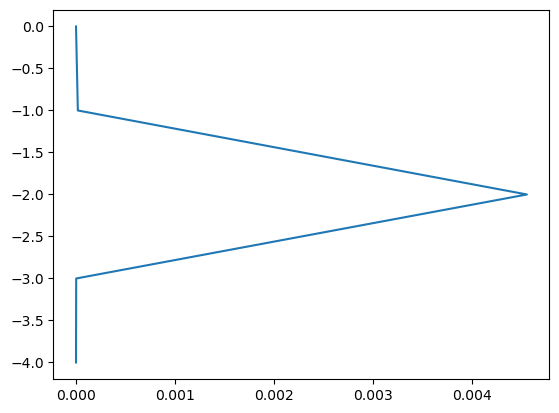

In [34]:
depth2 = np.arange(depth[0],depth[-1],1) # arrange for all depths, from the first to the last data in just 1 column 
Kz2 = np.interp(depth2, depth, Kz_col) # interpolation of Kz for depth 2, since there should be a difference in the vertical axis for depth vs W
plt.plot(Kz_col,-depth)
Kzp = np.gradient(Kz2, depth2[1]-depth2[0]) # gradient of the interpolated Kz
Kzp2 = np.gradient(Kzp, depth2[1]-depth2[0]) # gradient of the of the gradient of the interpolated Kz
dtmax = np.min(1/abs(Kzp2))
print(f'Dt should be << {dtmax}')

Text(0, 0.5, '2nd Gradient of Kz')

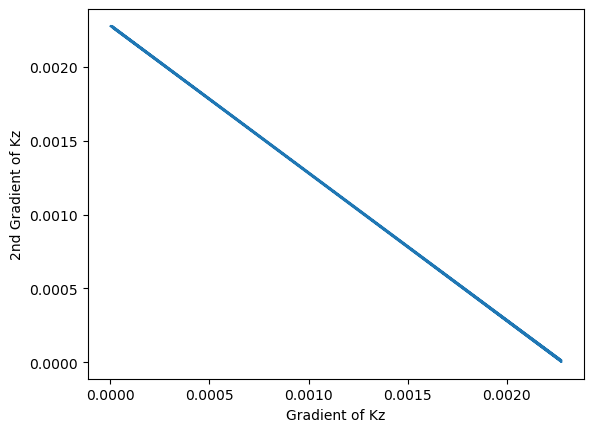

In [33]:
plt.plot(abs(Kzp),abs(Kzp2))
plt.xlabel('Gradient of Kz')
plt.ylabel('2nd Gradient of Kz')

In [22]:
#Here you can define as many particle variables as you want specifying the initial values. In this case, I use the variable to set a constant.
class MPParticle(JITParticle):
    Kh = Variable('Kh', initial =  10.0) #If you want horizontal mixing activated change value here
    bath = Variable('bath', initial= depth[-1])

In [24]:
#Mixing Kernel
def tu_mix(particle,fieldset,time):
    bath= particle.bath #109.73707
    if particle.depth+1 > bath: #Forward euler
        Kzdz = (fieldset.Kz[time,particle.depth,particle.lat, particle.lon]-fieldset.Kz[time,particle.depth-1,particle.lat, particle.lon]) #forward difference 
    else:
        Kzdz = (fieldset.Kz[time,particle.depth+1,particle.lat, particle.lon]-fieldset.Kz[time,particle.depth,particle.lat, particle.lon]) #backward difference 
    dgrad = Kzdz * particle.dt 
    if particle.depth+0.5*dgrad > 0 and particle.depth+0.5*dgrad < bath:
        kk = fieldset.Kz[time,particle.depth+0.5*dgrad,particle.lat, particle.lon] #Vertical diffusivity SSC  
    else:
        kk = fieldset.Kz[time, bath,particle.lat, particle.lon] #Vertical diffusivity SSC 
    Kx = particle.Kh
    Rr = ParcelsRandom.uniform(-1, 1)
    Rr2 = ParcelsRandom.uniform(-1, 1)
    d_random = sqrt(3*2*kk*particle.dt) * Rr
    d_randomx = sqrt(3*2*Kx*particle.dt) * Rr2
    Dlayerz = 0.5*sqrt(kk * particle.dt) #1m mixing layer
    Dlayerx = 0.5*sqrt(Kx * particle.dt)
    if particle.lon + d_randomx < 0:
        particle.lon = Dlayerx * ParcelsRandom.uniform(0, 1)
    elif particle.lon + d_randomx > 2e3:
        particle.lon = 2e3 - Dlayerx * ParcelsRandom.uniform(0, 1)
    else: 
        particle.lon=particle.lon + d_randomx
    if d_random + dgrad +particle.depth > bath: #randomly in boundary mixed layer
        particle.depth = bath - Dlayerz * ParcelsRandom.uniform(0, 1)
    elif d_random +particle.depth +dgrad < 0:
            particle.depth = Dlayerz * ParcelsRandom.uniform(0, 1) #Well mixed boundary layer
    else:
        particle.depth += d_random + dgrad 

In [25]:
#Define domain, velocity fields and Kz 
dim = 100
dep = len(depth)
lon = np.linspace(0., 2e3, dim, dtype=np.float32)

#Build fieldsets for OP
U = Field('U', np.zeros((dep, dim), dtype=np.float32), lon=lon, depth=depth)
V = Field('V', np.zeros((dep, dim), dtype=np.float32), lon=lon, depth=depth)
Kz_data = np.zeros((dep, dim), dtype=np.float32)
for i in range(dim):
    Kz_data[:,i]=Kz_col   
Kz = Field('Kz', Kz_data, grid=U.grid)
fieldset = FieldSet(U,V)
fieldset.add_field(Kz)

In [26]:
#Start with random distribution
lon_g = np.random.uniform(low=lon[0], high=lon[-1], size=(int(N),))
depth_g = np.random.uniform(low=depth[0], high=depth[-1], size=(int(N),))
lat_g = np.zeros(int(N),)

In [27]:
def run_turb_test(lon_g,depth_g):
    pset = ParticleSet(fieldset, pclass=MPParticle, lon=lon_g, depth=depth_g,lat = lat_g)
    output_file = pset.ParticleFile(name=outputpath, outputdt=outputdt)
    KE=tu_mix #if you want to add more kernels use:  KE = tu_mix + NAME_KERNEL1 + ...
    pset.execute(KE , runtime=T, dt=dt, output_file=output_file,recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle})

In [28]:
run_turb_test(lon_g,depth_g)

INFO: Compiled ArrayMPParticletu_mix ==> /tmp/parcels-2945/libedba2405ce84f7d3c76416bc665f5978_0.so
INFO: Output files are stored in /ocean/vvalenzuela/MOAD/analysis-vicente/results/2D_mixing_op1/Outputmix_op1.zarr.
100%|██████████| 50000.0/50000.0 [01:08<00:00, 725.39it/s] 


In [15]:
dat = xr.load_dataset('/ocean/vvalenzuela/MOAD/analysis-vicente/results/2D_mixing_op1/Outputmix_op1.zarr')

/home/vvalenzuela/miniforge3/lib/python3.10/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/vvalenzuela/miniforge3/lib/python3.10/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


In [16]:
def anim2(file1,fps=1):  
    box=([0,2e3,2e3,0,0],[0,0,depth[-1],depth[-1],0])
    fig,axs=plt.subplots(1,3,figsize=(15,10))
    axs[0].scatter(dat.lon[:,0],dat.z[:,0],s=5)
    #ax2 = axs[2].twiny()
    #ax2.plot(Kz_col,depth,c='r')
    axs[2].plot(Kz_col,depth,c='r')
    axs[2].set_title('Vertical profile $K_z$ [$m^2/s$]')
    axs[2].invert_yaxis()
    axs[0].plot(box[0],box[1],c='grey',linewidth=3)
    axs[1].plot(box[0],box[1],c='grey',linewidth=3)
    axs[0].invert_yaxis()
    axs[0].set_title('Initial condition (t: 0s)')
    axs[1].invert_yaxis()
    axs[1].set_title(f"With $K_z$' correction (t: {T:.2e}s)")
    axs[0].set_ylabel('Depth (m)')

    def update(frame):           
        global ss        
        for scat in ss:              
            scat.remove()            
        ss =[]                    
        ss.append(axs[1].scatter(file1.lon[:,frame],file1.z[:,frame],s=5,c ='tab:blue'))         
        print(f'{100*frame/len(file1):.2f}% completed')           
        return ss
    return animation.FuncAnimation(fig, update, frames=np.arange(0,len(file1),fps))

0.00% completed
0.00% completed
16.67% completed
33.33% completed
50.00% completed
66.67% completed
83.33% completed
0.00% completed


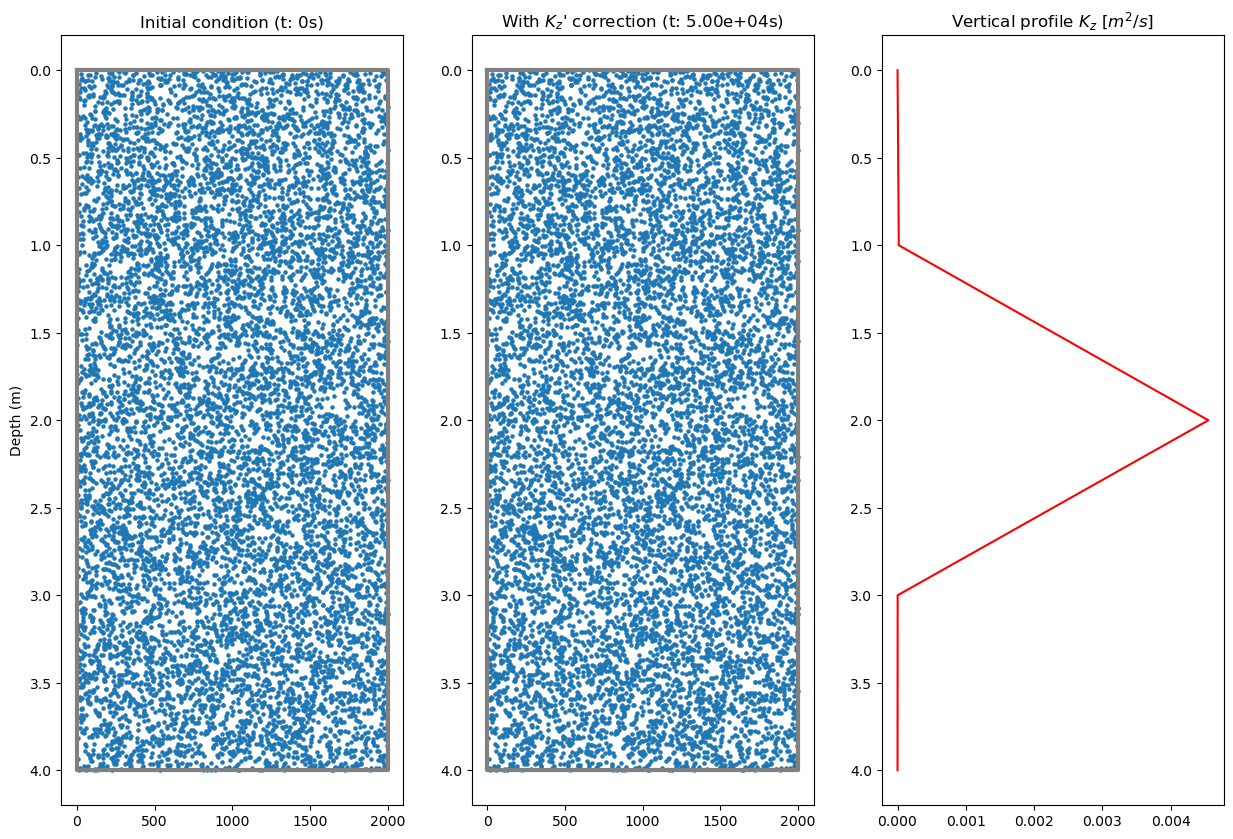

In [17]:
ss =[]
ani = anim2(dat,fps=1)
f = r"/ocean/vvalenzuela/MOAD/analysis-vicente/results/2D_mixing_op1/animations/mix_op1.gif" 
FFwriter = animation.FFMpegWriter()
a = ani.save(f, writer = FFwriter)

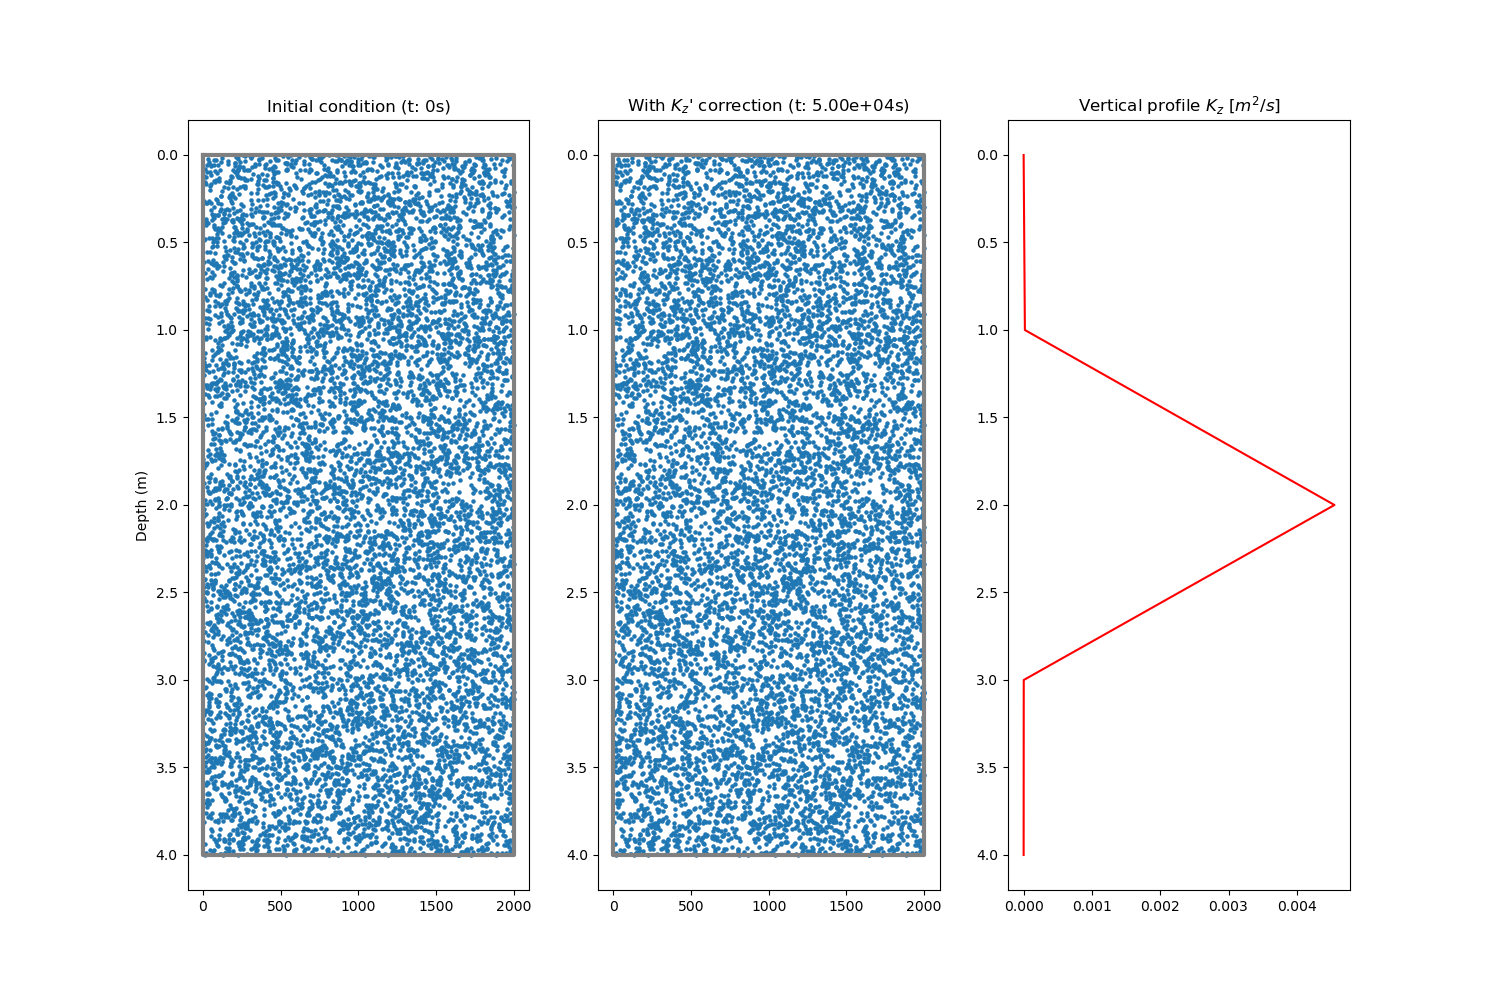

In [18]:
with open(f,'rb') as anim:
     display(Image(anim.read()))

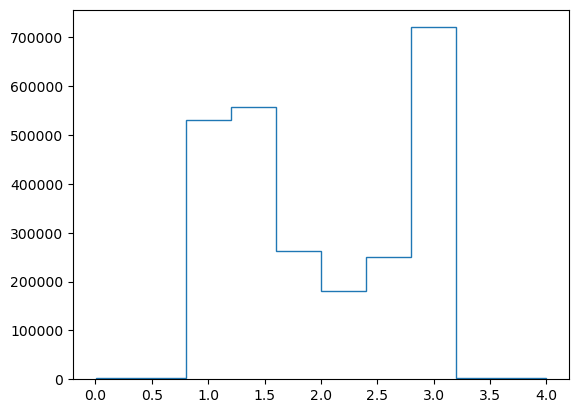

In [65]:
counts, bins = np.histogram(dat.z, bins = 10)
plt.stairs(counts, bins)